# Libraries

In [1]:
import random
import ray
import tensorflow as tf
import utils
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from environments.cartpole import CartPoleEnv

# Custom Model

In [2]:
class PPOCustomModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        inputs = tf.keras.layers.Input(shape=obs_space.shape, name='observations')
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model(inputs, [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])


# Default Model Train

2023-01-01 20:54:29,490	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-01 20:54:31,920	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
(RolloutWorker pid=14288) 2023-01-01 20:54:42,129	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-01-01 20:54:56,612	INFO trainable.py:172 -- Trainable.setup took 24.582 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-01-01 20:54:56,614	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 fc_2 (Dense)                   (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 fc_out (Dense)                 (None, 2)            514         ['fc_2[0][0]']                   
                                                                                              

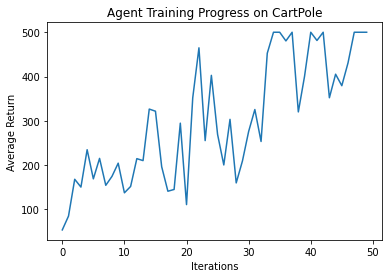

[53.4,
 84.6,
 167.8,
 150.2,
 234.6,
 168.8,
 215.0,
 154.2,
 174.4,
 204.2,
 137.2,
 151.6,
 214.4,
 210.0,
 326.4,
 321.6,
 196.2,
 140.8,
 144.8,
 294.6,
 110.6,
 351.8,
 464.8,
 255.2,
 402.6,
 269.2,
 200.2,
 303.2,
 159.6,
 209.0,
 275.8,
 325.4,
 253.2,
 452.6,
 500.0,
 500.0,
 480.4,
 500.0,
 320.0,
 400.4,
 500.0,
 481.4,
 500.0,
 352.0,
 405.2,
 379.2,
 430.8,
 500.0,
 500.0,
 500.0]

In [7]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
random.seed(0)
agent = PPO(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'vf_share_layers': True
    },
    'num_workers': 2,
    'rollout_fragment_length': 256,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'use_critic': True,
    'use_gae': True,
    'lambda': 0.95,
    'clip_param': 0.3,
    'kl_coeff': 0.2,
    'entropy_coeff': 0.01,
    'kl_target': 0.01,
    'vf_loss_coeff': 0.5,
    'shuffle_sequences': True,
    'num_sgd_iter': 40,
    'sgd_minibatch_size': 32,
    'train_batch_size': 512,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))

# Custom Model Train

2023-01-02 19:56:49,477	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-02 19:56:56,693	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
2023-01-02 19:56:56,694	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-02 19:56:56,753	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=6408) 2023-01-02 19:57:14,640	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 hidden_2 (Dense)               (None, 256)          65792       ['hidden_1[0][0]']               
                                                                                                  
 policy_out (Dense)             (None, 2)            514         ['hidden_2[0][0]']               
                                                                                              

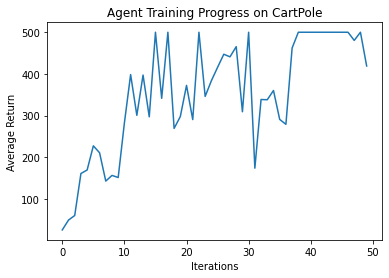

[25.6,
 49.2,
 60.2,
 161.0,
 169.4,
 227.4,
 210.8,
 142.8,
 156.4,
 151.4,
 282.6,
 398.4,
 300.6,
 397.2,
 297.0,
 500.0,
 341.4,
 500.0,
 269.2,
 297.6,
 372.4,
 290.4,
 500.0,
 346.0,
 383.6,
 415.8,
 447.2,
 441.0,
 465.4,
 309.2,
 500.0,
 173.8,
 338.6,
 338.0,
 360.2,
 290.8,
 279.0,
 462.2,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 480.4,
 500.0,
 419.0]

In [3]:
ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("ppo_model", PPOCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)
agent = PPO(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'vf_share_layers': True,
        'custom_model': 'ppo_model',
        'custom_model_config': {}
    },
    'num_workers': 2,
    'rollout_fragment_length': 256,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'use_critic': True,
    'use_gae': True,
    'lambda': 0.95,
    'clip_param': 0.3,
    'kl_coeff': 0.2,
    'entropy_coeff': 0.01,
    'kl_target': 0.01,
    'vf_loss_coeff': 0.5,
    'shuffle_sequences': True,
    'num_sgd_iter': 40,
    'sgd_minibatch_size': 32,
    'train_batch_size': 512,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))